Libraries imported successfully.
Data loaded successfully with 159 rows.
Data split into 127 training samples and 32 testing samples.

Training the XGBoost model...
✅ Model training complete.

--- Model Evaluation ---
Mean Absolute Error (MAE): 11.47
R-squared (R²) Score: 0.86
------------------------
Interpretation:
On average, the model's RUL prediction is off by ~11 cycles.
The model explains 86% of the variance in the RUL, which is a measure of its predictive power.


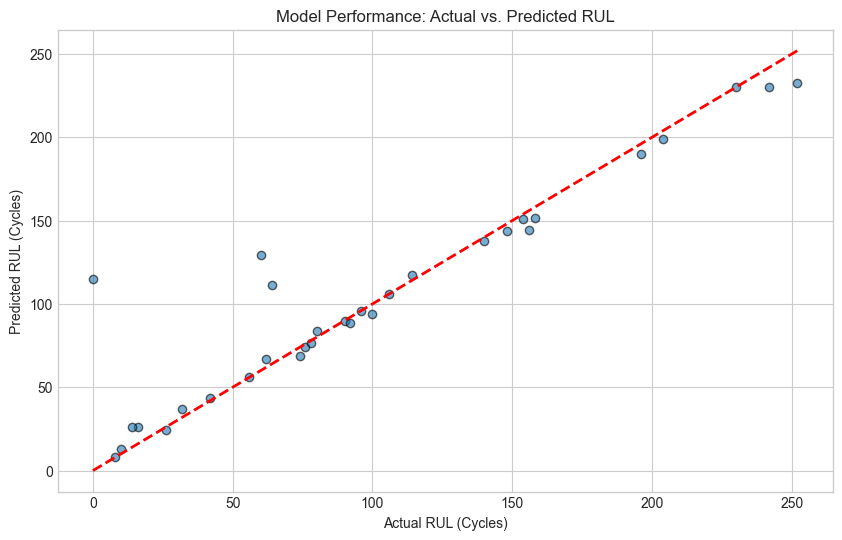

In [4]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

# --- 2. Load the Processed Data ---
DATA_PATH = '../data/processed_battery_data.csv'
df = pd.read_csv(DATA_PATH)

print(f"Data loaded successfully with {df.shape[0]} rows.")

# --- 3. Feature Selection and Data Splitting ---
# Define our features (X) and the target we want to predict (y)
features = [
    'cycle', 
    'capacity', 
    'temp_mean', 
    'voltage_mean', 
    'current_mean',
    'degradation_anomaly_score'
]
target = 'RUL'

X = df[features]
y = df[target]

# Split the data into training (80%) and testing (20%) sets
# random_state ensures we get the same split every time we run the code
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# --- 4. Train the XGBoost Model ---
# Initialize the XGBoost Regressor model with some good starting parameters
# n_estimators: number of trees in the forest
# learning_rate: how quickly the model learns
# max_depth: the maximum depth of a tree
xgbr = xgb.XGBRegressor(objective='reg:squarederror', 
                        n_estimators=1000, 
                        learning_rate=0.05,
                        max_depth=5,
                        early_stopping_rounds=10, # Stop training if performance doesn't improve
                        random_state=42)

print("\nTraining the XGBoost model...")

# Train the model on our training data
# We use the test set for evaluation during early stopping to prevent overfitting
xgbr.fit(X_train, y_train, 
         eval_set=[(X_test, y_test)], 
         verbose=False) # Set to True if you want to see training progress

print("✅ Model training complete.")


# --- 5. Evaluate the Model ---
# Make predictions on the test data (data the model has never seen before)
y_pred = xgbr.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²) Score: {r2:.2f}")
print("------------------------")
print("Interpretation:")
print(f"On average, the model's RUL prediction is off by ~{mae:.0f} cycles.")
print(f"The model explains {r2:.0%} of the variance in the RUL, which is a measure of its predictive power.")

# --- 6. Visualize the Results ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test, y_pred, alpha=0.6, edgecolors='k')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax.set_xlabel('Actual RUL (Cycles)')
ax.set_ylabel('Predicted RUL (Cycles)')
ax.set_title('Model Performance: Actual vs. Predicted RUL')
plt.show()

In [5]:
import joblib

# Define the file path for the saved model
MODEL_PATH = '../backend/rul_predictor_model.joblib'

# Save the trained model (xgbr) to the specified path
joblib.dump(xgbr, MODEL_PATH)

print(f"✅ Model saved successfully to: {MODEL_PATH}")


✅ Model saved successfully to: ../backend/rul_predictor_model.joblib
